# Exploring the cuisine of NYC neighborhoods 
> ## IBM Applied Data Science Capstone Project

<a name="tableofcontents"></a>

## Table of Contents
1. [Introduction](#introduction)
2. [Data](#data)
3. [Methodology](#methodology)
4. [Analysis & Machine Learning](#analysis)
5. [Results](#results)

<a name="introduction"></a>

## 1. Introduction

New York City is the most populous city in the United States, residence of many headquarters e.g.:  United Nations, international diplomacy, corporate companies. Residence of people from all over the world with different cultural backgrounds. Maybe it is the most diverse city (8.3 million people 800 languages) on the planet. These characteristics lead to high demand for various cuisine in NYC neighborhoods. This could be a very interesting opportunity for restaurant investors/owners to explore. 

Finding the right neighborhood for opening a new restaurant can be hard. Especially, in big cities like NYC. A restaurant owner/investor needs a lot of data to make a substantiated decision, in which neighborhood/location he is willing to open a restaurant for a certain cuisine.  

The idea of this project is to use Foursquare cuisine venue location data (using ‘Places API’) and regional clustering (using ‘K-means clustering unsupervised machine learning techniques’) to determine, which neighborhoods have potential to open a restaurant for a certain cuisine. This project will help to understand the cuisine diversity in neighborhoods and their surroundings. Exploratory Data Analysis will help to discover further details about cuisine diversity of the neighborhood. 

This analysis can be used for anyone who is interested in the distribution of different cuisines in NYC. It could be of interest for restaurant investors/owners, food specialist companies, Government for study propose etc. 

<a name="data"></a>[Scroll Back to Table of Contents](#tableofcontents)

## 2. Data

To examine the above said, following data sources will be used:

1.  **New York City Dataset**
    *  Link: <https://geo.nyu.edu/catalog/nyu_2451_34572>
    *  Description: This New York City Neighborhood Names point file was created as a guide to New York City’s neighborhoods that appear on the web resource, “New York: A City of Neighborhoods.” This dataset will provide the addresses of neighborhood of NYC in json format. An extract of the json is as follows:
    ```
	{'type': 'Feature',
	'id': 'nyu_2451_34572.306',
	'geometry': {'type': 'Point',
	'coordinates': [-74.08173992211962, 40.61731079252983]},
	'geometry_name': 'geom',
	'properties': {'name': 'Fox Hills',
	'stacked': 2,
	'annoline1': 'Fox',
	'annoline2': 'Hills',
	'annoline3': None,
	'annoangle': 0.0,
	'borough': 'Staten Island',
	'bbox': [-74.08173992211962,
	40.61731079252983,
	-74.08173992211962,
	40.61731079252983]}}
    ```

2.  **Foursquare API:**
    *  Link: <https://developer.foursquare.com/docs>
    *  Description: Foursquare API, a location data provider, will be used to make API calls to retrieve data about venues in different neighborhoods. This is the link to [Foursquare Venue Category Hierarchy](https://developer.foursquare.com/docs/resources/categories). Venues retrieved from all the neighborhoods are categorized broadly into "Arts & Entertainment", "College & University", "Event", "Food", "Nightlife Spot", "Outdoors & Recreation", etc. An extract of an API call is as follows:
    ```
	'categories': [{'id': '4bf58dd8d48988d110941735',
	   'name': 'Italian Restaurant',
	   'pluralName': 'Italian Restaurants',
	   'shortName': 'Italian',
	   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_',
	   'suffix': '.png'},
	   'primary': True}],
	'verified': False,
	'stats': {'tipCount': 17},
	'url': 'http://eccorestaurantny.com',
	'price': {'tier': 4, 'message': 'Very Expensive', 'currency'
    ```

<a name="methodology">[Scroll Back to Table of Contents](#tableofcontents)

## 2. Methodology

Download all the dependencies.

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from pprint import pprint # data pretty printer

import requests # library to handle requests
from bs4 import BeautifulSoup  # library to handle web scraping

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import folium # map rendering library

import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors # Matplotlib and associated plotting modules

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from collections import Counter # count occurrences 

from sklearn.cluster import KMeans # import k-means from clustering stage

### Download and Explore New York City Dataset

In order to segment the neighborhoods of New York City, a dataset is required that contains the 5 boroughs and the neighborhoods, that exist in each borough, with respective latitude and longitude coordinates.

This dataset exists for free on the web. Here is the link 
* To the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572, and
* To its downloadable json format file: https://cocl.us/new_york_dataset/newyork_data.json

In [3]:
!pip install wget

import wget
import os

if os.path.exists('newyork_data.json'):
    os.remove('newyork_data.json')

wget.download('https://cocl.us/new_york_dataset/newyork_data.json')

print('\nData downloaded!')

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=f50e66bc519499efd4aeb74f38afdd16396945fe9bd601dd6e62bd5bcfa49de4
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget

Data downloaded!


In [4]:
# open & load downloaded file, print its type
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
type(newyork_data)

dict

In [5]:
print ("newyork_data key and value's length are: ") 
for key, value in newyork_data.items(): 
    print (key, len(str(value)))

newyork_data key and value's length are: 
type 17
totalFeatures 3
features 124743
crs 70
bbox 74


All the relevant data is in the *features* key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [10]:
neighborhoods_data = newyork_data['features']
pprint(neighborhoods_data[305])

{'geometry': {'coordinates': [-74.08173992211962, 40.61731079252983],
              'type': 'Point'},
 'geometry_name': 'geom',
 'id': 'nyu_2451_34572.306',
 'properties': {'annoangle': 0.0,
                'annoline1': 'Fox',
                'annoline2': 'Hills',
                'annoline3': None,
                'bbox': [-74.08173992211962,
                         40.61731079252983,
                         -74.08173992211962,
                         40.61731079252983],
                'borough': 'Staten Island',
                'name': 'Fox Hills',
                'stacked': 2},
 'type': 'Feature'}


#### Tranform the data into a *pandas* dataframe

In [11]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Then let's loop through the data and fill the dataframe one row at a time.

In [12]:
for data in neighborhoods_data:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [ ]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [13]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Use geopy library to get the latitude and longitude values of New York City.

In [14]:
address = 'New York City, NY'
location = None

# define an instance of the geocoder -> ny_explorer
while location == None:
    try:
        geolocator = Nominatim(user_agent="ny_explorer")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
    except:
        pass
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a map of New York with neighborhoods superimposed on top.

In [15]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

**Folium** is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.

#### Define Foursquare Credentials and Version
Utilizing the Foursquare API to explore the neighborhoods and segment them.

In [16]:
##CLIENT_ID = 'XOKJYQNJOBDGS1WJQLVWK0KY2MX2LSBS2RQHYZ1IERYGZQM2' # your Foursquare ID
CLIENT_ID = 'V2AUPG5MZKKQZ45IYWHXXRY2RRO2KXKTLXTHX1JXIRCZ0B04' # your Foursquare ID
CLIENT_SECRET = 'UJ2WUKZ4KOAFSCFNAF2LZYOH3MKGGC4KPVLVTZCJ245OUECR' # your Foursquare Secret
##CLIENT_SECRET = 'JMKC15GZW4SFCQV32GOIZTXEJD4IHUGNM5L4U2SEXLBYPLHH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: V2AUPG5MZKKQZ45IYWHXXRY2RRO2KXKTLXTHX1JXIRCZ0B04
CLIENT_SECRET:UJ2WUKZ4KOAFSCFNAF2LZYOH3MKGGC4KPVLVTZCJ245OUECR


**Fetch Foursquare Venue Category Hierarchy**

In [17]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
category_results = requests.get(url).json()

Let's see the structure or the keys of the returned request.

In [18]:
for key, value in category_results['response']['categories'][0].items():
    print(key, len(str(value)))

id 24
name 20
pluralName 20
shortName 20
icon 98
categories 15910


In [19]:
category_list = category_results['response']['categories']

In [20]:
len(category_list)

10

In [21]:
for data in category_list:
    print(data['id'], data['name'])

4d4b7104d754a06370d81259 Arts & Entertainment
4d4b7105d754a06372d81259 College & University
4d4b7105d754a06373d81259 Event
4d4b7105d754a06374d81259 Food
4d4b7105d754a06376d81259 Nightlife Spot
4d4b7105d754a06377d81259 Outdoors & Recreation
4d4b7105d754a06375d81259 Professional & Other Places
4e67e38e036454776db1fb3a Residence
4d4b7105d754a06378d81259 Shop & Service
4d4b7105d754a06379d81259 Travel & Transport


**_Food_ & It's Sub-Categories**

Let's create a function to return a dictionary with Ids' & Names of _Food_ & It's Sub-Categories.

In [22]:
# function to flatten a 'parent_id' category, returns all categories if checkParentID = False
def flatten_Hierarchy(category_list, checkParentID, category_dict, parent_id = ''):
    for data in category_list:
        
        if checkParentID == True and data['id'] == parent_id:
            category_dict[data['id']] = data['name']
            flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
        
        elif checkParentID == False:
            category_dict[data['id']] = data['name']
            if len(data['categories']) != 0:
                flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
    
    return category_dict

In [23]:
# this function takes the parent ID and returns 'name' and 'id' of all the sub-categories
category_dict = flatten_Hierarchy(category_list, checkParentID=True, category_dict = {}, parent_id = '4d4b7105d754a06374d81259')

Now, we have all the categories in _Food_ with their id's.

#### Explore the first neighborhood to understand the results of GET Request

Get the neighborhood's name.

In [24]:
neighborhoods.loc[0, 'Neighborhood']

'Wakefield'

Get the neighborhood's latitude and longitude values.

In [25]:
neighborhood_latitude = neighborhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = neighborhoods.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Wakefield are 40.89470517661, -73.84720052054902.


#### Now, let's get the _Food_ that is in Wakefield within a radius of 500 meters.

First, let's create the GET request URL to search for Venue with requested _Category ID_

In [26]:
LIMIT = 1 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
categoryId = '4d4b7105d754a06374d81259' # category ID for "Food"

# create URL

url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius,
    categoryId,
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/search?&client_id=V2AUPG5MZKKQZ45IYWHXXRY2RRO2KXKTLXTHX1JXIRCZ0B04&client_secret=UJ2WUKZ4KOAFSCFNAF2LZYOH3MKGGC4KPVLVTZCJ245OUECR&v=20180605&ll=40.89470517661,-73.84720052054902&radius=500&categoryId=4d4b7105d754a06374d81259&limit=1'

#### Let's create a function to repeat the following process to all the neighborhoods in NYC:
* Loop through neighborhoods
    * Create the API request URL with radius=500, LIMIT=100
    * Make the GET request
    * For each neighborhood, return only relevant information for each nearby venue
    * Append all nearby venues to a list
* Unfold the list & append it to dataframe being returned

The _categoryId_ parameter in the API request URL can be a comma seperated string. So, lets create a comma seperated string from _category_\__dict_.

In [27]:
categoryId_list = []
for key, value in category_dict.items():
    categoryId_list.append(key)
categoryId = ','.join(categoryId_list)

The above process turns out to be redundant because if a top-level category is specified in the GET Request, all sub-categories will also match the query. But it is an interesting way to retrieve all the sub-categories ID with name.

In [28]:
def getNearbyFood(names, latitudes, longitudes, radius=1000, LIMIT=500):
    not_found = 0
    print('***Start ', end='')
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(' .', end='')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            "4d4b7105d754a06374d81259", # "Food" category id
            LIMIT)
            
        try:
            # make the GET request
            results = requests.get(url).json()['response']['venues']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
                v['categories'][0]['name']) for v in results])
        except:
            not_found += 1


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print("\nDone*** with {} venues with incompelete information.".format(not_found))
    return(nearby_venues)

**Let's use pickle library to serialize the information retrieved from GET requests. This step will counter any redundant requests to the Foursquare API.**

In [29]:
import pickle # to serialize and deserialize a Python object structure
try:
    with open('nyc_food_venues.pkl', 'rb') as f:
        nyc_venues = pickle.load(f)
    print("---Dataframe Existed and Deserialized---")
except:
    nyc_venues = getNearbyFood(names=neighborhoods['Neighborhood'],
                                        latitudes=neighborhoods['Latitude'],
                                        longitudes=neighborhoods['Longitude']
                                       )
    with open('nyc_food_venues.pkl', 'wb') as f:
        pickle.dump(nyc_venues, f)
    print("---Dataframe Created and Serialized---")

***Start  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Done*** with 0 venues with incompelete information.
---Dataframe Created and Serialized---


<a name="analysis"> [Scroll Back to Table of Contents](#tableofcontents)

## 3. Analysis & Machine Learning

#### Let's check the size of the resulting dataframe

In [31]:
print(nyc_venues.shape)
nyc_venues.head()

(13724, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Central Deli,40.896728,-73.844387,Deli / Bodega
1,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
2,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898083,-73.850259,Caribbean Restaurant
3,Wakefield,40.894705,-73.847201,Him Health Food Market,40.897665,-73.854638,Food
4,Wakefield,40.894705,-73.847201,Wakefield Deli,40.901998,-73.846910,Deli / Bodega


#### Let's find out how many unique categories can be curated from all the returned venues

In [32]:
print('There are {} uniques categories.'.format(len(nyc_venues['Venue Category'].unique())))
nyc_venues.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 190 uniques categories.


Venue Category
Deli / Bodega                               1266
Pizza Place                                 1084
Coffee Shop                                  936
Chinese Restaurant                           684
Donut Shop                                   644
Fast Food Restaurant                         601
Bakery                                       584
Italian Restaurant                           447
Bagel Shop                                   397
Café                                         379
Mexican Restaurant                           377
Ice Cream Shop                               332
Sandwich Place                               325
Caribbean Restaurant                         322
Fried Chicken Joint                          310
American Restaurant                          304
Food                                         242
Diner                                        242
Restaurant                                   229
Food Truck                                   206
Burge

As we are interested in exploring the diversity of the neighborhood. Let's remove the generalized categories, like Coffee Shop, Cafe, etc.

In [33]:
# list all the categories
unique_categories = nyc_venues['Venue Category'].unique().tolist()
print(', '.join(str(x) for x in unique_categories))

Deli / Bodega, Ice Cream Shop, Caribbean Restaurant, Food, Fast Food Restaurant, Fried Chicken Joint, Sandwich Place, Donut Shop, Chinese Restaurant, Pizza Place, Spanish Restaurant, American Restaurant, Coffee Shop, Food Truck, Mexican Restaurant, Bakery, Bagel Shop, Seafood Restaurant, Dumpling Restaurant, BBQ Joint, African Restaurant, Restaurant, Diner, Juice Bar, Grocery Store, Wings Joint, Café, Asian Restaurant, Breakfast Spot, Burger Joint, Steakhouse, Sushi Restaurant, Tapas Restaurant, Latin American Restaurant, Frozen Yogurt Shop, Bar, Italian Restaurant, Empanada Restaurant, Japanese Restaurant, Greek Restaurant, Indian Restaurant, Thai Restaurant, Noodle House, Comfort Food Restaurant, Korean Restaurant, Vegetarian / Vegan Restaurant, Cuban Restaurant, Pub, Fish & Chips Shop, Falafel Restaurant, Cafeteria, Salvadoran Restaurant, Soup Place, Southern / Soul Food Restaurant, Other Nightlife, Arcade, New American Restaurant, Taco Place, Dessert Shop, Health Food Store, French

In [34]:
# manually create a list of generalized categories
general_categories = ['Dessert Shop','Food','Ice Cream Shop','Donut Shop','Bakery','Sandwich Place','Comfort Food Restaurant',
                    'Deli / Bodega','Food Truck','Bagel Shop','Burger Joint','Restaurant','Frozen Yogurt Shop','Coffee Shop',
                    'Diner','Wings Joint','Café','Juice Bar','Breakfast Spot','Grocery Store','Bar','Cupcake Shop',
                    'Pub','Fish & Chips Shop','Cafeteria','Other Nightlife','Arcade','Hot Dog Joint','Food Court',
                    'Health Food Store','Convenience Store','Food & Drink Shop','Cocktail Bar','Cheese Shop',
                    'Snack Place','Sports Bar','Lounge','Theme Restaurant','Buffet','Bubble Tea Shop','Building',
                    'Irish Pub','College Cafeteria','Tea Room','Supermarket','Hotpot Restaurant','Gastropub','Beer Garden',
                    'Fish Market','Beer Bar','Clothing Store','Music Venue','Bistro','Salad Place','Wine Bar','Gourmet Shop',
                    'Indie Movie Theater','Art Gallery','Gift Shop','Pie Shop','Fruit & Vegetable Store',
                    'Street Food Gathering','Dive Bar','Factory','Farmers Market','Mac & Cheese Joint','Creperie',
                    'Candy Store','Event Space','Skating Rink','Miscellaneous Shop','Gas Station','Organic Grocery',
                    'Pastry Shop','Club House','Flea Market','Hotel','Furniture / Home Store','Bookstore','Pet Café',
                    'Gym / Fitness Center','Flower Shop','Financial or Legal Service','Hotel Bar','Hookah Bar','Poke Place',
                    'Market','Gluten-free Restaurant','Smoothie Shop','Butcher','Food Stand','Beach Bar','Beach',
                    'Soup Place','Rock Club','Residential Building (Apartment / Condo)','Laundry Service',
                    'Government Building','Bowling Alley','Nightclub','Park','Moving Target','Bike Shop','Beer Store',
                    'Hobby Shop','Chocolate Shop','Food Service','Indoor Play Area','Record Shop','Whisky Bar','Dosa Place']

In [35]:
# fetch all the required food categories
food_categories =  list(set(unique_categories) - set(general_categories))
print(', '.join(str(x) for x in food_categories))

BBQ Joint, Falafel Restaurant, Lebanese Restaurant, Pakistani Restaurant, Asian Restaurant, New American Restaurant, American Restaurant, Modern European Restaurant, Australian Restaurant, Taco Place, Portuguese Restaurant, Indian Restaurant, French Restaurant, Caucasian Restaurant, Colombian Restaurant, Thai Restaurant, Japanese Curry Restaurant, Dim Sum Restaurant, Cantonese Restaurant, Hawaiian Restaurant, Ukrainian Restaurant, Egyptian Restaurant, Jewish Restaurant, Persian Restaurant, Venezuelan Restaurant, Afghan Restaurant, Peruvian Restaurant, German Restaurant, African Restaurant, Korean Restaurant, Cuban Restaurant, Caribbean Restaurant, Eastern European Restaurant, Salvadoran Restaurant, Varenyky restaurant, North Indian Restaurant, Modern Greek Restaurant, Taiwanese Restaurant, Burrito Place, Mediterranean Restaurant, Mexican Restaurant, Austrian Restaurant, Ramen Restaurant, Chinese Restaurant, Latin American Restaurant, Indian Chinese Restaurant, Filipino Restaurant, Pout

Let's remove all the generalized categories, like Coffee Shop, Cafe, etc.

In [36]:
nyc_venues = nyc_venues[nyc_venues['Venue Category'].isin(food_categories)].reset_index()
nyc_venues.head(5)

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,2,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898083,-73.850259,Caribbean Restaurant
1,5,Wakefield,40.894705,-73.847201,Burger King,40.895540,-73.856460,Fast Food Restaurant
2,6,Wakefield,40.894705,-73.847201,Golden Krust Caribbean Restaurant,40.903773,-73.850051,Caribbean Restaurant
3,7,Wakefield,40.894705,-73.847201,Popeyes Louisiana Kitchen,40.889322,-73.843323,Fried Chicken Joint
4,9,Wakefield,40.894705,-73.847201,McDonald's,40.892779,-73.857473,Fast Food Restaurant


In [37]:
print('There are {} unique FOOD categories.'.format(len(nyc_venues['Venue Category'].unique())))

There are 89 unique FOOD categories.


#### Let's find out how many unique venues can be curated from all the returned venues

In [38]:
print('There are {} uniques venues.'.format(len(nyc_venues['Venue'].unique())))

There are 3158 uniques venues.


### Analyze Each Neighborhood

In [39]:
# one hot encoding
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")
nyc_onehot.head()

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Brazilian Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Indian Chinese Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Turkish Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Yemeni Restaurant
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [40]:
# add neighborhood column back to dataframe
nyc_onehot['Neighborhood'] = nyc_venues['Neighborhood'] 
nyc_onehot.head()

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Brazilian Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Indian Chinese Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Turkish Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Yemeni Restaurant,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield


In [41]:
# move neighborhood column to the first column
Neighborhood = nyc_onehot['Neighborhood']

nyc_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
nyc_onehot.insert(0, 'Neighborhood', Neighborhood)

nyc_onehot.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Brazilian Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Indian Chinese Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Turkish Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Yemeni Restaurant
0,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [42]:
nyc_onehot.shape

(6483, 90)

Let's count venues of each category in each neighborhood

In [43]:
venue_counts = nyc_onehot.groupby('Neighborhood').sum()
venue_counts.head(5)

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Brazilian Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Indian Chinese Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Turkish Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Yemeni Restaurant
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Allerton,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,5,0,0,0,0,0,0,0,0,0,3,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Annadale,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0
Arden Heights,0,0,3,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
Arlington,0,0,2,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arrochar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


Let's find out the top 10 food categories in NYC

In [44]:
venue_counts_described = venue_counts.describe().transpose()

In [45]:
venue_top10 = venue_counts_described.sort_values('max', ascending=False)[0:10]
venue_top10

,count,mean,std,min,25%,50%,75%,max
Korean Restaurant,302.0,0.238411,1.426883,0.0,0.0,0.0,0.0,22.0
Chinese Restaurant,302.0,2.264901,1.887895,0.0,1.0,2.0,3.0,13.0
Caribbean Restaurant,302.0,1.066225,2.393704,0.0,0.0,0.0,1.0,13.0
Italian Restaurant,302.0,1.480132,1.760947,0.0,0.0,1.0,2.0,11.0
Fast Food Restaurant,302.0,1.990066,1.941820,0.0,0.0,2.0,3.0,11.0
Indian Restaurant,302.0,0.311258,0.894319,0.0,0.0,0.0,0.0,10.0
Pizza Place,302.0,3.589404,1.995915,0.0,2.0,3.0,5.0,9.0
Seafood Restaurant,302.0,0.533113,0.906178,0.0,0.0,0.0,1.0,8.0
Fried Chicken Joint,302.0,1.026490,1.314105,0.0,0.0,1.0,2.0,7.0
Asian Restaurant,302.0,0.500000,0.857835,0.0,0.0,0.0,1.0,6.0


In [46]:
venue_top10_list = venue_top10.index.values.tolist()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


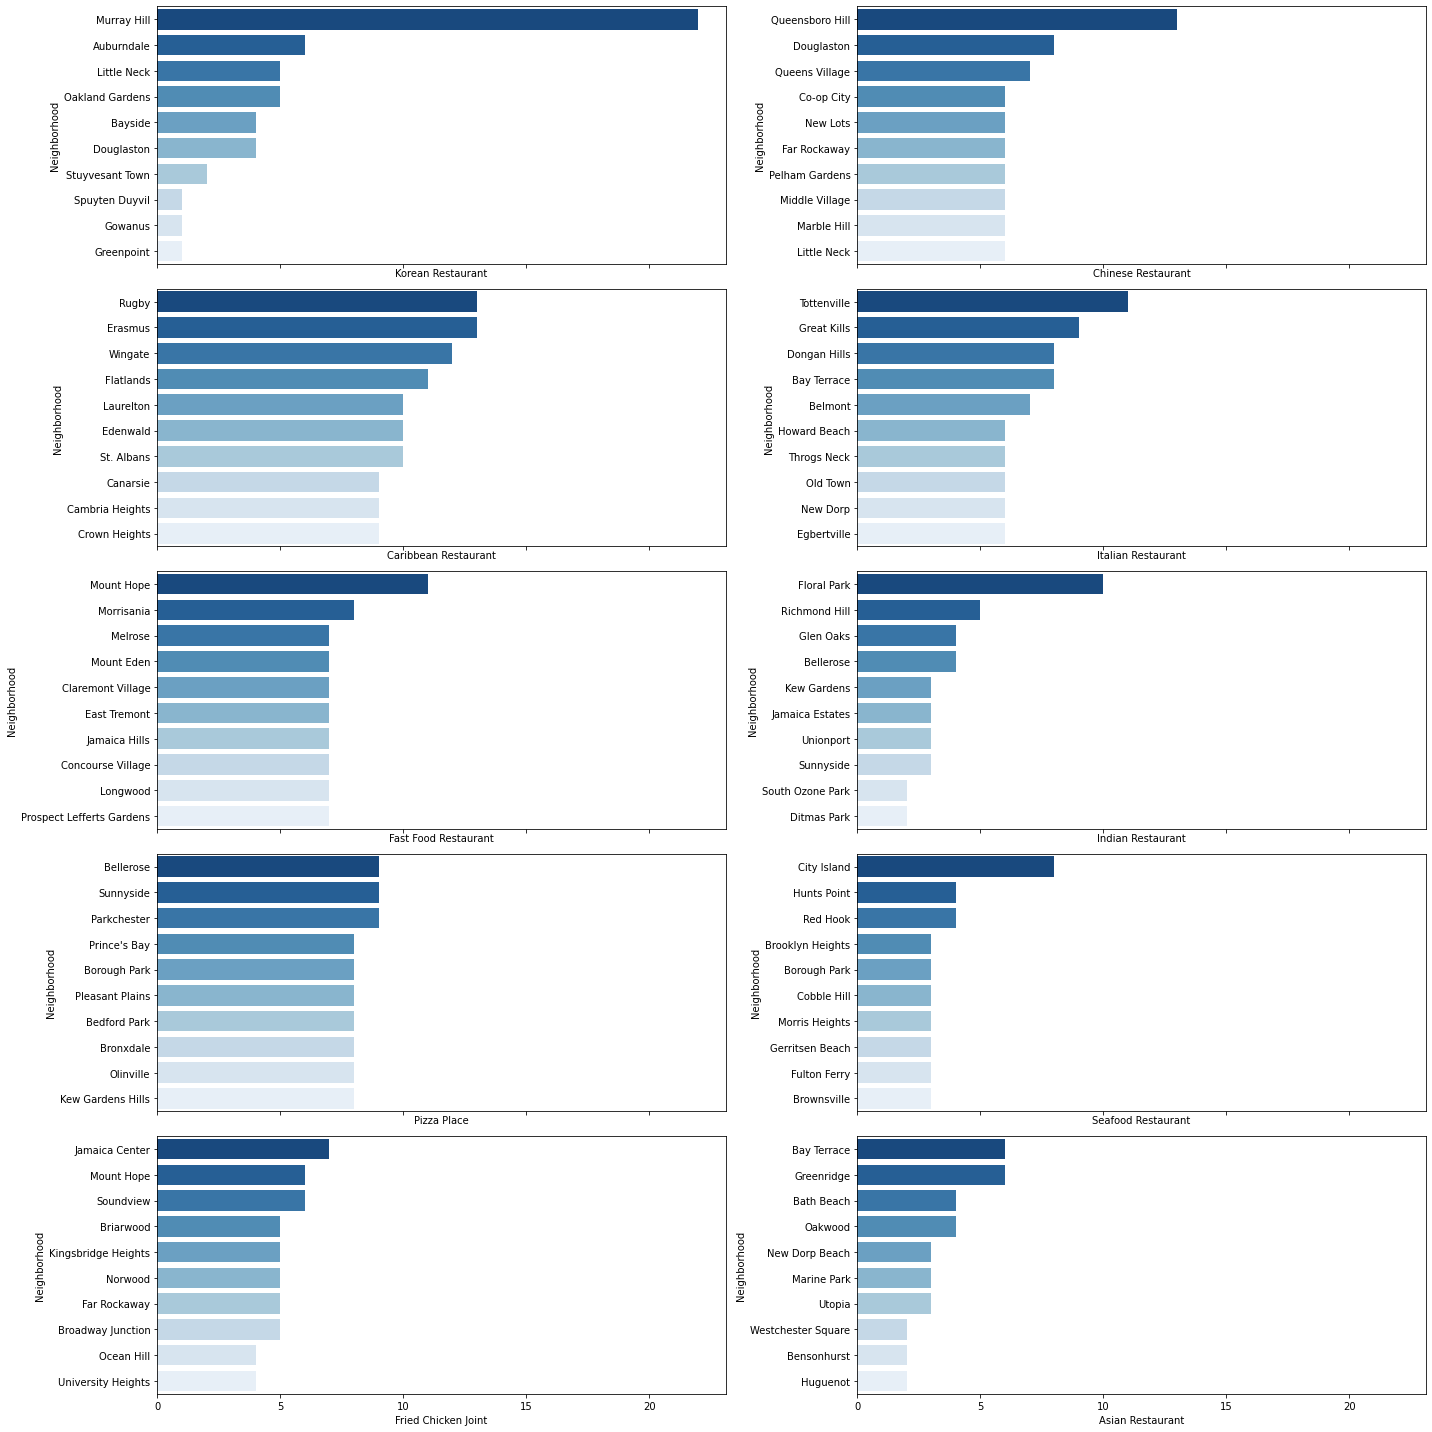

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes =plt.subplots(5, 2, figsize=(20,20), sharex=True)
axes = axes.flatten()

for ax, category in zip(axes, venue_top10_list):
    data = venue_counts[[category]].sort_values([category], ascending=False)[0:10]
    pal = sns.color_palette("Blues", len(data))
    sns.barplot(x=category, y=data.index, data=data, ax=ax, palette=np.array(pal[::-1]))

plt.tight_layout()
plt.show();

**Top 10 cuisine and neighboorhood **

*   Korean restaurant   : Moray Hill
*   Chinese rstaurant   : QueensBoro Hill
*   Caribean restaurant : Rugby/Erasmus
*   talian restaurant   : Tottenfille
*   Fast food restaurant: Mount Hope
*   Indian restuuarant  : Floral Park
*   Pizza Place         : Bellerose/Sunnyside/Parkchester
*   Seafood             : City Island
*   fried chicken joint : Jamaica centre
*   Asian restuarant    : bay terrace/greenritch


  










#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [48]:
nyc_grouped = nyc_onehot.groupby('Neighborhood').mean().reset_index()
nyc_grouped.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Brazilian Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Indian Chinese Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Turkish Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Yemeni Restaurant
0,Allerton,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.045455,0.0,0.227273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.136364,0.0,0.0,0.136364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.181818,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.227273,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045455,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Annadale,0.0,0.0,0.166667,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.055556,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.333333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.166667,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Arden Heights,0.0,0.0,0.157895,0.0,0.0,0.000000,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,0.000000,0.0,0.105263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.157895,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.105263,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.315789,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.105263,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arlington,0.0,0.0,0.111111,0.0,0.0,0.055556,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.055556,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.055556,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.055556,0.277778,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.111111,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Arrochar,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.307692,0.0,0.076923,0.0,0.0,0.0,0.0,0.076923,0.0,0.0,0.076923,0.000000,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.153846,0.076923,0.0,0.0,

#### Let's confirm the new size

In [49]:
nyc_grouped.shape

(302, 90)

#### Let's write a function to sort the venues in descending order.

In [50]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 5 venues for each neighborhood.

In [51]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))    

In [52]:
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = nyc_grouped['Neighborhood']

In [53]:
for ind in np.arange(nyc_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Allerton,Pizza Place,Chinese Restaurant,Mexican Restaurant,Fast Food Restaurant,Fried Chicken Joint
1,Annadale,Pizza Place,American Restaurant,Italian Restaurant,Sushi Restaurant,Japanese Restaurant
2,Arden Heights,Pizza Place,American Restaurant,Italian Restaurant,Mexican Restaurant,Chinese Restaurant
3,Arlington,Pizza Place,Fast Food Restaurant,American Restaurant,Spanish Restaurant,Latin American Restaurant
4,Arrochar,Italian Restaurant,Pizza Place,Latin American Restaurant,Japanese Restaurant,Mediterranean Restaurant


### Cluster Neighborhoods

Run *k*-means to count Neighborhoods for each cluster label for variable cluster size

In [54]:
nyc_grouped_clustering = nyc_grouped.drop('Neighborhood', 1)

#### Determine the optimal number of clusters for k-means clustering

**The Elbow Method** - calculate the sum of squared distances of samples to their closest cluster center for different values of k. The value of k after which there is no siginificant decrease in sum of squared distances is choosen.

In [55]:
sum_of_squared_distances = []
K = range(1,50)
for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k).fit(nyc_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

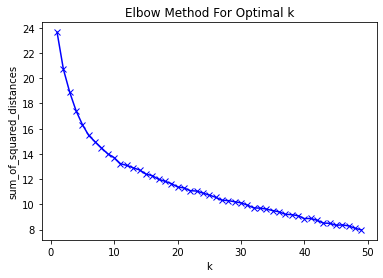

In [ ]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k');

Elbow method does not seem to help us to determine the optimal number of clusters. Let's use another method.

**The Silhouette Method** - The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation). Source: Wikipedia

In [ ]:
from sklearn.metrics import silhouette_score

sil = []
K_sil = range(2,50)
# minimum 2 clusters required, to define dissimilarity
for k in K_sil:
    print(k, end=' ')
    kmeans = KMeans(n_clusters = k).fit(nyc_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(nyc_grouped_clustering, labels, metric = 'euclidean'))

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

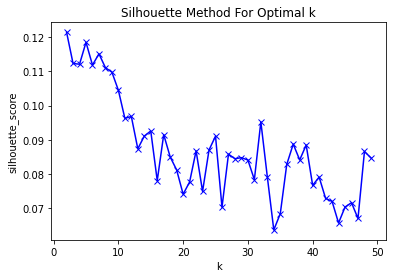

In [ ]:
plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Method For Optimal k')
plt.show()

There is a peak at k = 2, k = 4 and k = 8. Two and four clusters will give a very broad classification of the venues.
#### Let's set number of clusters = 8

In [ ]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=50).fit(nyc_grouped_clustering)

print(Counter(kmeans.labels_))

Counter({0: 61, 3: 55, 4: 53, 2: 46, 7: 32, 1: 27, 6: 25, 5: 3})


Let's create a new dataframe that includes the cluster as well as the top 5 venues for each neighborhood.

In [ ]:
# add clustering labels
try:
    neighborhoods_venues_sorted.drop('Cluster Labels', axis=1)
except:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [ ]:
neighborhoods_venues_sorted.head(5)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,2,Allerton,Pizza Place,Chinese Restaurant,Mexican Restaurant,Fried Chicken Joint,Fast Food Restaurant
1,3,Annadale,Pizza Place,American Restaurant,Italian Restaurant,Sushi Restaurant,Japanese Restaurant
2,3,Arden Heights,Pizza Place,American Restaurant,Italian Restaurant,Mexican Restaurant,Chinese Restaurant
3,3,Arlington,Pizza Place,American Restaurant,Fast Food Restaurant,Spanish Restaurant,Caribbean Restaurant
4,7,Arrochar,Italian Restaurant,Pizza Place,Japanese Restaurant,Polish Restaurant,Latin American Restaurant


In [ ]:
# merge neighborhoods_venues_sorted with nyc_data to add latitude/longitude for each neighborhood
nyc_merged = neighborhoods_venues_sorted.join(neighborhoods.set_index('Neighborhood'), on='Neighborhood')
nyc_merged.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
0,2,Allerton,Pizza Place,Chinese Restaurant,Mexican Restaurant,Fried Chicken Joint,Fast Food Restaurant,Bronx,40.865788,-73.859319
1,3,Annadale,Pizza Place,American Restaurant,Italian Restaurant,Sushi Restaurant,Japanese Restaurant,Staten Island,40.538114,-74.178549
2,3,Arden Heights,Pizza Place,American Restaurant,Italian Restaurant,Mexican Restaurant,Chinese Restaurant,Staten Island,40.549286,-74.185887
3,3,Arlington,Pizza Place,American Restaurant,Fast Food Restaurant,Spanish Restaurant,Caribbean Restaurant,Staten Island,40.635325,-74.165104
4,7,Arrochar,Italian Restaurant,Pizza Place,Japanese Restaurant,Polish Restaurant,Latin American Restaurant,Staten Island,40.596313,-74.067124


Finally, let's visualize the resulting clusters

In [ ]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged['Latitude'], nyc_merged['Longitude'], nyc_merged['Neighborhood'], nyc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='results'></a>[Scroll Back to Table of Contents](#tableofcontents)

## 5. Results

In [ ]:
required_column_indices = [2,3,7]
required_column = [list(nyc_merged.columns.values)[i] for i in required_column_indices]
required_column_indices = [2,3,7]

#### Cluster 0

In [ ]:
cluster_0 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 0, nyc_merged.columns[1:12]]
cluster_0.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
5,Arverne,Pizza Place,Chinese Restaurant,American Restaurant,Asian Restaurant,Thai Restaurant,Queens,40.589144,-73.791992
7,Astoria Heights,Greek Restaurant,Pizza Place,Chinese Restaurant,Italian Restaurant,Indian Restaurant,Queens,40.770317,-73.894680
8,Auburndale,Korean Restaurant,Pizza Place,Greek Restaurant,Chinese Restaurant,Italian Restaurant,Queens,40.761730,-73.791762
9,Bath Beach,Vietnamese Restaurant,Cantonese Restaurant,Chinese Restaurant,Asian Restaurant,Fast Food Restaurant,Brooklyn,40.599519,-73.998752
13,Baychester,Chinese Restaurant,Fast Food Restaurant,Caribbean Restaurant,Pizza Place,Spanish Restaurant,Bronx,40.866858,-73.835798


In [ ]:
for col in required_column:
    print(cluster_0[col].value_counts(ascending = False))
    print("---------------------------------------------")

Chinese Restaurant       27
Pizza Place              26
Sushi Restaurant          2
Korean Restaurant         2
Greek Restaurant          1
American Restaurant       1
Fried Chicken Joint       1
Vietnamese Restaurant     1
Caribbean Restaurant      1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Chinese Restaurant       22
Pizza Place              12
Italian Restaurant        4
Fast Food Restaurant      4
Korean Restaurant         3
Cantonese Restaurant      2
Greek Restaurant          2
Fried Chicken Joint       2
Indian Restaurant         2
Japanese Restaurant       2
Sushi Restaurant          1
Vietnamese Restaurant     1
Russian Restaurant        1
Mexican Restaurant        1
Caribbean Restaurant      1
American Restaurant       1
Taco Place                1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Queens           30
Brooklyn         11
Staten Island    10
Bronx             6
Manhattan       

#### Cluster 1

In [ ]:
cluster_1 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 1, nyc_merged.columns[1:12]]
cluster_1.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
10,Battery Park City,Fast Food Restaurant,Seafood Restaurant,Mediterranean Restaurant,Italian Restaurant,American Restaurant,Manhattan,40.711932,-74.016869
24,Bergen Beach,Sushi Restaurant,American Restaurant,Pizza Place,Middle Eastern Restaurant,Moroccan Restaurant,Brooklyn,40.615150,-73.898556
27,Boerum Hill,Pizza Place,New American Restaurant,Italian Restaurant,Seafood Restaurant,Cuban Restaurant,Brooklyn,40.685683,-73.983748
31,Brighton Beach,Eastern European Restaurant,Russian Restaurant,Pizza Place,Seafood Restaurant,Fast Food Restaurant,Brooklyn,40.576825,-73.965094
44,Carroll Gardens,Pizza Place,Italian Restaurant,Seafood Restaurant,French Restaurant,Ramen Restaurant,Brooklyn,40.680540,-73.994654


In [ ]:
for col in required_column:
    print(cluster_1[col].value_counts(ascending = False))
    print("---------------------------------------------")

Pizza Place                    7
Italian Restaurant             6
American Restaurant            6
Seafood Restaurant             3
Sushi Restaurant               2
Eastern European Restaurant    1
New American Restaurant        1
Fast Food Restaurant           1
Spanish Restaurant             1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
American Restaurant        8
Italian Restaurant         5
Pizza Place                5
Seafood Restaurant         4
Russian Restaurant         2
Turkish Restaurant         1
New American Restaurant    1
Mexican Restaurant         1
Spanish Restaurant         1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Brooklyn         13
Manhattan         6
Bronx             5
Staten Island     2
Queens            2
Name: Borough, dtype: int64
---------------------------------------------


#### Cluster 2

In [ ]:
cluster_2 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 2, nyc_merged.columns[1:12]]
cluster_2.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
0,Allerton,Pizza Place,Chinese Restaurant,Mexican Restaurant,Fried Chicken Joint,Fast Food Restaurant,Bronx,40.865788,-73.859319
30,Briarwood,Fast Food Restaurant,Fried Chicken Joint,Pizza Place,Chinese Restaurant,Latin American Restaurant,Queens,40.710935,-73.811748
33,Broadway Junction,Fried Chicken Joint,Pizza Place,Fast Food Restaurant,Chinese Restaurant,Mexican Restaurant,Brooklyn,40.677861,-73.903317
47,Central Harlem,Pizza Place,Fast Food Restaurant,Southern / Soul Food Restaurant,American Restaurant,Fried Chicken Joint,Manhattan,40.815976,-73.943211
52,City Line,Fast Food Restaurant,Pizza Place,Latin American Restaurant,Chinese Restaurant,Fried Chicken Joint,Brooklyn,40.678570,-73.867976


In [ ]:
for col in required_column:
    print(cluster_2[col].value_counts(ascending = False))
    print("---------------------------------------------")

American Restaurant        7
Pizza Place                6
Seafood Restaurant         3
New American Restaurant    1
Spanish Restaurant         1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
American Restaurant    6
Pizza Place            6
Italian Restaurant     3
Seafood Restaurant     3
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Brooklyn         8
Bronx            4
Queens           3
Staten Island    2
Manhattan        1
Name: Borough, dtype: int64
---------------------------------------------


#### Cluster 3

In [ ]:
cluster_3 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 3, nyc_merged.columns[1:12]]
cluster_3.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
1,Annadale,Pizza Place,American Restaurant,Italian Restaurant,Sushi Restaurant,Japanese Restaurant,Staten Island,40.538114,-74.178549
2,Arden Heights,Pizza Place,American Restaurant,Italian Restaurant,Mexican Restaurant,Chinese Restaurant,Staten Island,40.549286,-74.185887
3,Arlington,Pizza Place,American Restaurant,Fast Food Restaurant,Spanish Restaurant,Caribbean Restaurant,Staten Island,40.635325,-74.165104
6,Astoria,Pizza Place,Greek Restaurant,Italian Restaurant,Fast Food Restaurant,Thai Restaurant,Queens,40.768509,-73.915654
16,Bedford Park,Pizza Place,Chinese Restaurant,Fast Food Restaurant,Mexican Restaurant,Fried Chicken Joint,Bronx,40.870185,-73.885512


In [ ]:
for col in required_column:
    print(cluster_3[col].value_counts(ascending = False))
    print("---------------------------------------------")

Chinese Restaurant       23
Pizza Place              14
Sushi Restaurant          4
Korean Restaurant         2
Greek Restaurant          1
Caribbean Restaurant      1
Vietnamese Restaurant     1
American Restaurant       1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Chinese Restaurant       13
Pizza Place              11
Italian Restaurant        4
Korean Restaurant         3
Fast Food Restaurant      3
Greek Restaurant          2
American Restaurant       2
Cantonese Restaurant      2
Russian Restaurant        2
Fried Chicken Joint       1
Indian Restaurant         1
Vietnamese Restaurant     1
Taco Place                1
Japanese Restaurant       1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Queens           22
Brooklyn         11
Staten Island     7
Manhattan         4
Bronx             3
Name: Borough, dtype: int64
---------------------------------------------


#### Cluster 4

In [ ]:
cluster_4 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 4, nyc_merged.columns[1:12]]
cluster_4.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
11,Bay Ridge,Pizza Place,Fried Chicken Joint,Chinese Restaurant,Mexican Restaurant,Yemeni Restaurant,Brooklyn,40.625801,-74.030621
25,Blissville,Pizza Place,Italian Restaurant,Chinese Restaurant,Mexican Restaurant,Fast Food Restaurant,Queens,40.737251,-73.932442
43,Carnegie Hill,Mexican Restaurant,American Restaurant,Italian Restaurant,Pizza Place,Chinese Restaurant,Manhattan,40.782683,-73.953256
57,Clinton,Mexican Restaurant,Pizza Place,Thai Restaurant,Taco Place,Empanada Restaurant,Manhattan,40.759101,-73.996119
66,Corona,Mexican Restaurant,Latin American Restaurant,Pizza Place,Fried Chicken Joint,Italian Restaurant,Queens,40.742382,-73.856825


In [ ]:
for col in required_column:
    print(cluster_4[col].value_counts(ascending = False))
    print("---------------------------------------------")

Pizza Place         63
Taco Place           1
Asian Restaurant     1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Chinese Restaurant             16
Italian Restaurant             12
American Restaurant            11
Sushi Restaurant                3
Fast Food Restaurant            3
Greek Restaurant                2
Pizza Place                     2
Indian Restaurant               2
BBQ Joint                       2
Mexican Restaurant              2
Thai Restaurant                 2
Seafood Restaurant              1
Latin American Restaurant       1
Japanese Restaurant             1
Spanish Restaurant              1
Eastern European Restaurant     1
Sri Lankan Restaurant           1
New American Restaurant         1
Caribbean Restaurant            1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Staten Island    29
Queens           14
Brooklyn         12
Bronx             9
Manhattan         1
Name: Bor

#### Cluster 5

In [ ]:
cluster_5 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 5, nyc_merged.columns[1:12]]
cluster_5.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
40,Butler Manor,Italian Restaurant,Asian Restaurant,BBQ Joint,Chinese Restaurant,Fried Chicken Joint,Staten Island,40.506082,-74.229504
152,Lighthouse Hill,Italian Restaurant,Yemeni Restaurant,Greek Restaurant,Empanada Restaurant,English Restaurant,Staten Island,40.576506,-74.137927
271,Tottenville,Italian Restaurant,Pizza Place,Mexican Restaurant,Asian Restaurant,Chinese Restaurant,Staten Island,40.505334,-74.246569


In [ ]:
for col in required_column:
    print(cluster_5[col].value_counts(ascending = False))
    print("---------------------------------------------")

Caribbean Restaurant    22
Fast Food Restaurant     2
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Chinese Restaurant      8
Pizza Place             6
Fried Chicken Joint     4
Fast Food Restaurant    4
Caribbean Restaurant    2
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Brooklyn    12
Queens       8
Bronx        4
Name: Borough, dtype: int64
---------------------------------------------


#### Cluster 6

In [ ]:
cluster_6 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 6, nyc_merged.columns[1:12]]
cluster_6.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
17,Bedford Stuyvesant,Caribbean Restaurant,Fried Chicken Joint,French Restaurant,Southern / Soul Food Restaurant,Pizza Place,Brooklyn,40.687232,-73.941785
36,Brookville,Caribbean Restaurant,Fried Chicken Joint,Pizza Place,Chinese Restaurant,Fast Food Restaurant,Queens,40.660003,-73.751753
37,Brownsville,Caribbean Restaurant,Pizza Place,Chinese Restaurant,Seafood Restaurant,American Restaurant,Brooklyn,40.663950,-73.910235
41,Cambria Heights,Caribbean Restaurant,Chinese Restaurant,African Restaurant,Pizza Place,Latin American Restaurant,Queens,40.692775,-73.735269
42,Canarsie,Caribbean Restaurant,Chinese Restaurant,Fast Food Restaurant,Pizza Place,Mexican Restaurant,Brooklyn,40.635564,-73.902093


In [ ]:
for col in required_column:
    print(cluster_6[col].value_counts(ascending = False))
    print("---------------------------------------------")

Caribbean Restaurant    23
American Restaurant      1
Fast Food Restaurant     1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Chinese Restaurant      8
Pizza Place             7
Fried Chicken Joint     5
Fast Food Restaurant    4
Caribbean Restaurant    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Brooklyn         12
Queens            8
Bronx             4
Staten Island     1
Name: Borough, dtype: int64
---------------------------------------------


#### Cluster 7

In [ ]:
cluster_7 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 7, nyc_merged.columns[1:12]]
cluster_7.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
4,Arrochar,Italian Restaurant,Pizza Place,Japanese Restaurant,Polish Restaurant,Latin American Restaurant,Staten Island,40.596313,-74.067124
12,Bay Terrace,Italian Restaurant,Pizza Place,Asian Restaurant,American Restaurant,Chinese Restaurant,Queens,40.782843,-73.776802
12,Bay Terrace,Italian Restaurant,Pizza Place,Asian Restaurant,American Restaurant,Chinese Restaurant,Staten Island,40.553988,-74.139166
20,Belle Harbor,Seafood Restaurant,Italian Restaurant,Mexican Restaurant,BBQ Joint,Chinese Restaurant,Queens,40.576156,-73.854018
22,Belmont,Italian Restaurant,Fast Food Restaurant,Pizza Place,Mexican Restaurant,Chinese Restaurant,Bronx,40.857277,-73.888452


In [ ]:
for col in required_column:
    print(cluster_7[col].value_counts(ascending = False))
    print("---------------------------------------------")

Italian Restaurant     26
Pizza Place             5
Seafood Restaurant      1
American Restaurant     1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Pizza Place             14
Italian Restaurant       7
Mexican Restaurant       4
Fast Food Restaurant     3
Chinese Restaurant       2
Asian Restaurant         1
American Restaurant      1
Japanese Restaurant      1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Staten Island    15
Queens           11
Bronx             3
Manhattan         2
Brooklyn          2
Name: Borough, dtype: int64
---------------------------------------------
